⚡ Loading cached features
Risk classes: ['No Risk' 'Price Variance Risk' 'Split PO']
📊 Classification Report (per label):
                     precision    recall  f1-score   support

            No Risk       1.00      1.00      1.00      2536
Price Variance Risk       1.00      1.00      1.00       445
           Split PO       1.00      0.88      0.94        34

          micro avg       1.00      1.00      1.00      3015
          macro avg       1.00      0.96      0.98      3015
       weighted avg       1.00      1.00      1.00      3015
        samples avg       1.00      1.00      1.00      3015



C:\Users\ajayn\anaconda3\envs\node2vec-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


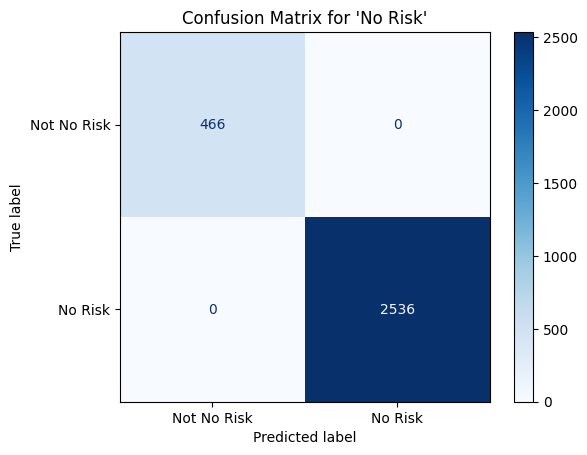

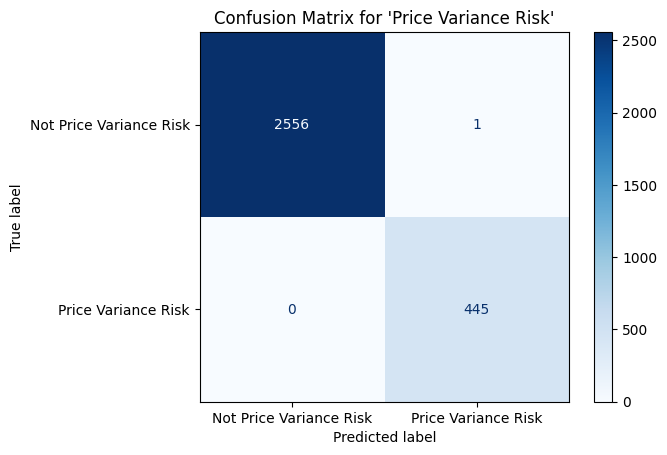

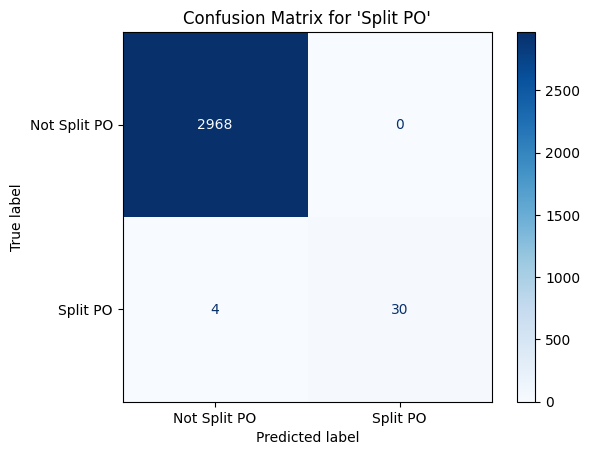

  Predicted Risks
0      (No Risk,)
1      (No Risk,)
2      (No Risk,)
3      (No Risk,)
4      (No Risk,)
✅ Model and artifacts saved successfully.


In [2]:
##############################################################################
#  Cell 1 — Imports & common paths
##############################################################################
import os
import json
import pandas as pd
import numpy as np
import psycopg2
import joblib
import logging
from typing import List
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import LocalOutlierFactor
import logging
from sklearn.metrics import (
    r2_score,
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error
)
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
from typing import Optional

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set options to show full DataFrame output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from pathlib import Path
from datetime import timedelta
import joblib, json, warnings
import numpy as np
import pandas as pd
from __future__ import annotations
import argparse
from typing import Any, Dict
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)

RAW_PO      = Path("po_output.pkl") #("../Po_Invoice_Data/po_output_tushar.pkl")      # raw PO data (input)
FEAT_PO     = Path("Po_Invoice_Data/po_output_features_df_risk.pkl")         # engineered features
#MODEL_PKL   = Path("Po_Invoice_Data/po_gbdt_model.pkl")         # tuned model file
#CV_REPORT   = Path("Po_Invoice_Data/cv_results.csv")            # param grid results
#SCORING_OUT = Path("Po_Invoice_Data/scored_po.pkl")             # predictions file

# -----------------------------------------------------------------------------
# 1) Column standardisation helper
# -----------------------------------------------------------------------------

# Final rule to sub-risk mapping
def get_sub_risks(row):
    rule_to_subrisk = {
        "P2P02067": "Price Variance Risk",
        "P2P02068": "Price Variance Risk",
        "P2P02070": "Split PO",
        "P2P02072": "Split PO"
    }
    risks = {rule_to_subrisk[rule] for rule in rule_to_subrisk if row.get(rule, 0) == 1}
    return list(risks) if risks else ["No Risk"]
def sub_risk(df):    
    
    # Step 1: Assign Main Risk Scenario
    df["Main Risk Scenario"] = df["rft_by_engine_po"].apply(
        lambda x: "Procurement Risk" if x else "No Risk"
    )
    
    # Step 2: Generate clean list of sub risks
    #def get_sub_risks(row):
        #risks = {rule_to_subrisk[rule] for rule in rule_to_subrisk if row.get(rule, 0) == 1}
        #return list(risks) if risks else ["No Risk"]
    
    df["Sub Risks"] = df.apply(get_sub_risks, axis=1)
    
    return df


COL_MAP: Dict[str, str] = {
    # raw_column                          # internal name
    "vendor_or_creditor_acct_no_hpd_po": "vendor_id",
    "material_no_src_po": "material_id",
    "purch_doc_date_hpd_po": "po_date",
    "doc_change_date_src_po": "po_change_date",
    "net_price_doc_curr_src_po": "net_price",
    "gross_val_po_curr_src_po": "gross_val",
    "exchange_rate_hpd_po": "exch_rate",
    "requester_name_src_po": "requester",
    # unit‑conversion numerators / denominators
    "p2o_unit_conv_num_src_po": "p2o_num",
    "p2o_unit_conv_denom_src_po": "p2o_den",
    "o2b_unit_conv_num_src_po": "o2b_num",
    "o2b_unit_conv_denom_src_po": "o2b_den",
}

# -----------------------------------------------------------------------------
# 2) Feature engineering functions (pure, chainable)
# -----------------------------------------------------------------------------

def _prep(df: pd.DataFrame) -> pd.DataFrame:
    """Rename key columns, parse dates & fill obvious nulls."""
    #df = df.rename(columns={k: v for k, v in COL_MAP.items() if k in df.columns})
    df["purch_doc_date_hpd_po"] = pd.to_datetime(df["purch_doc_date_hpd_po"], errors="coerce")
    df["doc_change_date_src_po"] = pd.to_datetime(df.get("doc_change_date_src_po"), errors="coerce")
    df["vendor_or_creditor_acct_no_hpd_po"] = df.get("vendor_or_creditor_acct_no_hpd_po", "UNKNOWN").fillna("UNKNOWN")
    df["requester_name_src_po"] = df.get("requester_name_src_po", "UNKNOWN").fillna("UNKNOWN")
    df["exchange_rate_hpd_po"] = df.get("exchange_rate_hpd_po", 1.0).replace({0: np.nan}).fillna(1.0)
    return df

# -----------------------------------------------------------------------------
# 2a) Rule‑based features (rules 1,2,3,5)
# -----------------------------------------------------------------------------

def add_rule_metrics(df: pd.DataFrame,
                     split_days: int = 60,
                     price_var_days: int = 365) -> pd.DataFrame:
    """Add features mirroring Baldota P2P rules.

    * vm_count/value = aggregation for **same vendor+material** within *split_days*
    * vm_price_var_pct = price deviation (%) vs mean of past *price_var_days*
    * mat_vendor_cnt & mat_price_var_pct analogues for material across vendors
    """
    df = df.copy()
    df.sort_values("purch_doc_date_hpd_po", inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Initialise
    df["vm_count_%dd" % split_days] = 0
    df["vm_value_%dd" % split_days] = 0.0
    df["vm_price_var_pct_%dd" % price_var_days] = 0.0
    df["mat_vendor_cnt_%dd" % split_days] = 0
    df["mat_price_var_pct_%dd" % price_var_days] = 0.0

    # Pre‑extract convenient arrays for speed
    po_dates = df["purch_doc_date_hpd_po"].values
    prices = df.get("net_price_doc_curr_src_po").astype(float).values
    vals = df.get("gross_val_po_curr_src_po").astype(float).values

    # --- Same vendor + material group logic ----------------------------------
    for (v, m), idx in df.groupby(["vendor_or_creditor_acct_no_hpd_po", "material_no_src_po"]).groups.items():
        d = po_dates[idx]
        p = prices[idx]
        vls = vals[idx]
        for loc, ridx in enumerate(idx):
            cur = d[loc]
            # split window
            win_mask = (d >= cur - np.timedelta64(split_days, "D")) & (d <= cur)
            df.iat[ridx, df.columns.get_loc("vm_count_%dd" % split_days)] = int(win_mask.sum())
            df.iat[ridx, df.columns.get_loc("vm_value_%dd" % split_days)] = float(vls[win_mask].sum())
            # price variance window
            var_mask = (d >= cur - np.timedelta64(price_var_days, "D")) & (d <= cur)
            if var_mask.sum() > 1:
                mean_price = p[var_mask].mean()
                if mean_price:
                    pct = abs(p[loc] - mean_price) / mean_price * 100
                    df.iat[ridx, df.columns.get_loc("vm_price_var_pct_%dd" % price_var_days)] = pct

    # --- Material‑only group logic -------------------------------------------
    for m, idx in df.groupby("material_no_src_po").groups.items():
        d = po_dates[idx]
        p = prices[idx]
        vendors = df.loc[idx, "vendor_or_creditor_acct_no_hpd_po"].values
        for loc, ridx in enumerate(idx):
            cur = d[loc]
            win_mask = (d >= cur - np.timedelta64(split_days, "D")) & (d <= cur)
            df.iat[ridx, df.columns.get_loc("mat_vendor_cnt_%dd" % split_days)] = int(len(set(vendors[win_mask])))
            var_mask = (d >= cur - np.timedelta64(price_var_days, "D")) & (d <= cur)
            if var_mask.sum() > 1:
                mean_price = p[var_mask].mean()
                if mean_price:
                    pct = abs(p[loc] - mean_price) / mean_price * 100
                    df.iat[ridx, df.columns.get_loc("mat_price_var_pct_%dd" % price_var_days)] = pct

    return df

# -----------------------------------------------------------------------------
# 2b) Value & process metrics
# -----------------------------------------------------------------------------

def add_value_and_timing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["conv_factor_p2o"] = (
        df.get("p2o_unit_conv_num_src_po") / df.get("p2o_unit_conv_denom_src_po")
    ).replace({np.inf: np.nan, -np.inf: np.nan})
    df["conv_factor_o2b"] = (
        df.get("o2b_unit_conv_num_src_po") / df.get("o2b_unit_conv_denom_src_po")
    ).replace({np.inf: np.nan, -np.inf: np.nan})

    df["po_change_lag_days"] = (df.get("doc_change_date_src_po") - df["purch_doc_date_hpd_po"]).dt.days
    df["base_value"] = df.get("gross_val_po_curr_src_po") * df.get("exchange_rate_hpd_po")
    p95 = df["gross_val_po_curr_src_po"].quantile(0.95)
    df["high_value_flag"] = (df["gross_val_po_curr_src_po"] >= p95).astype(int)
    return df

# -----------------------------------------------------------------------------
# 2c) Behavioural rolling windows
# -----------------------------------------------------------------------------

def _rolling_stats(df: pd.DataFrame, group_col: str, days: int,
                   count_col: str, sum_col: str) -> pd.DataFrame:
    df = df.copy()
    df[count_col] = 0
    df[sum_col] = 0.0

    po_dates = df["purch_doc_date_hpd_po"].values
    gross_vals = df["gross_val_po_curr_src_po"].values

    for key, idx in df.groupby(group_col).groups.items():
        dates = po_dates[idx]
        vals = gross_vals[idx]
        for loc, ridx in enumerate(idx):
            cur = dates[loc]
            mask = (dates >= cur - np.timedelta64(days, "D")) & (dates <= cur)
            df.iat[ridx, df.columns.get_loc(count_col)] = int(mask.sum())
            df.iat[ridx, df.columns.get_loc(sum_col)] = float(vals[mask].sum())
    return df


def add_behavioural_stats(df: pd.DataFrame, window_days: int = 30) -> pd.DataFrame:
    df = _rolling_stats(df, "requester_name_src_po", window_days,
                        "req_po_count_%dd" % window_days,
                        "req_val_sum_%dd" % window_days)
    df = _rolling_stats(df, "vendor_or_creditor_acct_no_hpd_po", window_days,
                        "vendor_po_count_%dd" % window_days,
                        "vendor_val_sum_%dd" % window_days)
    return df

# -----------------------------------------------------------------------------
# 3) Public orchestrator
# -----------------------------------------------------------------------------

def build_features(raw_df: pd.DataFrame) -> pd.DataFrame:
    """End‑to‑end feature generator (no target leakage)."""
    df = _prep(raw_df)
    df = add_rule_metrics(df)
    df = add_value_and_timing(df)
    df = add_behavioural_stats(df)
    return df

def flag_split_po(df):
    df = df.copy()
    df['split_po_flag'] = 0  # Default 0

    # Apply exclusion filters only for computation
    exclude_doc_types = ["AN", "AR", "MN", "QC", "QI", "QS", "RS", "SC", "SG", "SR", "SS", "ST", "TP", "TR", "UB", "WK"]

    filtered = df[
        (~df['purch_doc_type_hpd_po'].isin(exclude_doc_types)) &
        (df['purch_doc_type_hpd_po'].notna()) &
        (~(df['po_item_del_flag_src_po'] == 'L')) &
        (~df['plant_src_po'].fillna("").astype(str).str.startswith("4")) &
        (df['release_indicator_hpd_po'] == 'R') &
        (df['gross_val_po_curr_src_po'] >= 10) &
        (df['purch_doc_date_hpd_po'].notna()) &
        (df['vendor_or_creditor_acct_no_hpd_po'].notna()) &
        (df['company_code_src_po'].notna())
    ].copy()

    filtered['purch_doc_date_hpd_po'] = pd.to_datetime(filtered['purch_doc_date_hpd_po'])

    def get_group_key(row):
        if pd.notna(row['material_no_src_po']):
            return f"{row['vendor_or_creditor_acct_no_hpd_po']}__{row['material_no_src_po']}"
        elif pd.notna(row['short_text_src_po']):
            return f"{row['vendor_or_creditor_acct_no_hpd_po']}__{row['short_text_src_po']}"
        else:
            return np.nan

    filtered['split_key'] = filtered.apply(get_group_key, axis=1)
    filtered = filtered[filtered['split_key'].notna()].copy()
    filtered.sort_values(['split_key', 'purch_doc_date_hpd_po'], inplace=True)

    flagged_po_set = set()

    for key, group in filtered.groupby('split_key'):
        dates = group['purch_doc_date_hpd_po'].reset_index(drop=True)
        po_nos = group['purch_doc_no_src_po'].reset_index(drop=True)

        for i in range(len(dates)):
            date_i = dates[i]
            po_i = po_nos[i]
            mask = (
                (dates >= date_i - pd.Timedelta(days=14)) &
                (dates <= date_i + pd.Timedelta(days=14)) &
                (po_nos != po_i)
            )
            if mask.sum() > 0:
                flagged_po_set.add(po_i)

    # Assign flag only to matching rows in original df
    df['split_po_flag'] = df['purch_doc_no_src_po'].isin(flagged_po_set).astype(int)
    return df
def flag_intra_po_split(df, gross_threshold=10):
    df = df.copy()
    df['intra_po_split_flag'] = 0  # Default

    df_valid = df[
        df['gross_val_po_curr_src_po'].notna() &
        df['vendor_or_creditor_acct_no_hpd_po'].notna() &
        df['material_no_src_po'].notna() &
        df['purch_doc_no_src_po'].notna()
    ].copy()

    group_cols = ['purch_doc_no_src_po', 'vendor_or_creditor_acct_no_hpd_po', 'material_no_src_po']
    grouped = df_valid.groupby(group_cols)

    flagged_indexes = []

    for _, group in grouped:
        total_gross = group['gross_val_po_curr_src_po'].sum()
        num_items = len(group)
        all_below_threshold = group['gross_val_po_curr_src_po'].all()

        if total_gross >= gross_threshold and num_items > 1 and all_below_threshold:
            flagged_indexes.extend(group.index.tolist())

    df.loc[flagged_indexes, 'intra_po_split_flag'] = 1
    return df
def flag_multiple_pos_per_pr_item(df):
    df = df.copy()
    df['multi_po_per_pr_flag'] = 0  # Default

    # Only consider approved POs with valid PR and PR item
    df_valid = df[
        (df['release_indicator_hpd_po'] == 'R') &
        df['pr_no_src_po'].notna() &
        df['pr_item_no_src_po'].notna() &
        df['purch_doc_no_src_po'].notna()
    ][['pr_no_src_po', 'pr_item_no_src_po', 'purch_doc_no_src_po']].drop_duplicates()

    # Count number of unique POs per PR+Item
    po_counts = df_valid.groupby(['pr_no_src_po', 'pr_item_no_src_po'])['purch_doc_no_src_po'].nunique()

    # Identify PR+Items linked to more than one PO
    multi_po_keys = po_counts[po_counts > 1].index.tolist()

    # Create a set for fast lookup
    multi_po_set = set(multi_po_keys)

    # Flag in the main DataFrame
    df['multi_po_per_pr_flag'] = df.apply(
        lambda row: 1 if (row['pr_no_src_po'], row['pr_item_no_src_po']) in multi_po_set else 0,
        axis=1
    )

    return df
def flag_same_vendor_price_increase(df, price_increase_threshold=0.05, months_range=6, flag_column='same_vendor_price_increase_flag'):
    df = df.copy()
    df[flag_column] = 0

    df_valid = df[
        (df['release_indicator_hpd_po'] == 'R') &
        (df['material_no_src_po'].notna()) &
        (df['vendor_or_creditor_acct_no_hpd_po'].notna()) &
        (df['net_price_doc_curr_src_po'].notna()) &
        (df['purch_doc_date_hpd_po'].notna())
    ].copy()

    df_valid['purch_doc_date_hpd_po'] = pd.to_datetime(df_valid['purch_doc_date_hpd_po'])
    df_valid.sort_values(['vendor_or_creditor_acct_no_hpd_po', 'material_no_src_po', 'purch_doc_date_hpd_po'], inplace=True)

    group_cols = ['vendor_or_creditor_acct_no_hpd_po', 'material_no_src_po']
    flagged_indices = []

    for _, group in df_valid.groupby(group_cols):
        group = group.sort_values('purch_doc_date_hpd_po').reset_index()

        for i in range(1, len(group)):
            current_row = group.loc[i]
            current_date = current_row['purch_doc_date_hpd_po']
            current_price = current_row['net_price_doc_curr_src_po']

            mask = group.loc[:i-1, 'purch_doc_date_hpd_po'] >= current_date - pd.DateOffset(months=months_range)
            past_group = group.loc[:i-1][mask]

            if not past_group.empty:
                last_price = past_group['net_price_doc_curr_src_po'].iloc[-1]
                if last_price > 0 and ((current_price - last_price) / last_price) >= price_increase_threshold:
                    flagged_indices.append(current_row['index'])

    df.loc[flagged_indices, flag_column] = 1
    return df
def flag_diff_vendor_price_variance(df, price_variance_threshold=0.05, months_range=6, flag_column='diff_vendor_price_variance_flag'):
    df = df.copy()
    df[flag_column] = 0

    df_valid = df[
        (df['release_indicator_hpd_po'] == 'R') &
        (df['material_no_src_po'].notna()) &
        (df['vendor_or_creditor_acct_no_hpd_po'].notna()) &
        (df['net_price_doc_curr_src_po'].notna()) &
        (df['purch_doc_date_hpd_po'].notna())
    ].copy()

    df_valid['purch_doc_date_hpd_po'] = pd.to_datetime(df_valid['purch_doc_date_hpd_po'])
    df_valid = df_valid.sort_values(['material_no_src_po', 'purch_doc_date_hpd_po'])

    for material, mat_group in df_valid.groupby('material_no_src_po'):
        mat_group = mat_group.sort_values('purch_doc_date_hpd_po').reset_index()

        for i in range(len(mat_group)):
            current_row = mat_group.loc[i]
            current_date = current_row['purch_doc_date_hpd_po']
            current_price = current_row['net_price_doc_curr_src_po']

            past_window = mat_group[
                (mat_group['purch_doc_date_hpd_po'] < current_date) &
                (mat_group['purch_doc_date_hpd_po'] >= current_date - pd.DateOffset(months=months_range))
            ]

            vendor_prices = past_window.groupby('vendor_or_creditor_acct_no_hpd_po')['net_price_doc_curr_src_po'].mean()
            if not vendor_prices.empty:
                max_price = vendor_prices.max()
                min_price = vendor_prices.min()
                if max_price > 0 and (max_price - min_price) / max_price >= price_variance_threshold:
                    df.loc[current_row['index'], flag_column] = 1

    return df

def final_parsing(df):
        # === Parse Date Columns ===
    date_cols = [
        "doc_change_date_src_po",
        "doc_change_date_hpd_po",
        "purch_doc_date_hpd_po"
    ]
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")
    
    # === Feature Engineering ===
    
    # A. Date Features
    df["po_doc_age_days"] = (df["doc_change_date_hpd_po"] - df["purch_doc_date_hpd_po"]).dt.days
    df["lead_time_po_vs_pr"] = (df["purch_doc_date_hpd_po"] - df["doc_change_date_src_po"]).dt.days
    df["po_day_of_week"] = df["purch_doc_date_hpd_po"].dt.dayofweek
    df["po_day_of_month"] = df["purch_doc_date_hpd_po"].dt.day
    df["po_month"] = df["purch_doc_date_hpd_po"].dt.month
    
    # B. Price & Value Features
    df["price_per_unit"] = df["net_val_po_curr_src_po"] / df["quantity_src_po"].replace(0, np.nan)
    df["net_vs_gross_delta"] = df["gross_val_po_curr_src_po"] - df["net_val_po_curr_src_po"]
    df["price_variance_percent"] = (df["net_val_po_curr_src_po"] - df["gross_val_po_curr_src_po"]) / df["gross_val_po_curr_src_po"].replace(0, np.nan)
    df["outline_agrmt_coverage"] = df["outline_agrmt_tgt_val_doc_curr_src_po"] / df["net_val_po_curr_src_po"].replace(0, np.nan)
    
    # C. PO-PR Linkage Flags
    df["has_pr_link"] = df["pr_no_src_po"].notna().astype(int)
    df["has_pr_item_link"] = df["pr_item_no_src_po"].notna().astype(int)
    
    # D. Flags & Indicators
    binary_cols = [
        "gr_indicator_src_po", "gr_invoice_verif_flag_src_po",
        "inv_receipt_indicator_src_po", "release_indicator_hpd_po",
        "release_status_hpd_po", "doc_release_incompl_flag_hpd_po"
    ]
    for col in binary_cols:
        if col in df.columns:
            df[col + "_flag"] = df[col].notna().astype(int)
    
    # E. Missing Signal
    critical_cols = [
        "material_type_src_po", "material_no_src_po",
        "vendor_or_creditor_acct_no_hpd_po", "gross_val_po_curr_src_po",
        "net_price_doc_curr_src_po"
    ]
    df["missing_critical_fields"] = df[critical_cols].isnull().sum(axis=1)
    
    # F. Currency & Exchange Rate
    df["has_exchange_rate"] = df["exchange_rate_hpd_po"].notna().astype(int)
    df["log_exchange_rate"] = np.log1p(df["exchange_rate_hpd_po"].fillna(0))
    
    # G. Unit Conversion Features
    df["p2o_conversion_ratio"] = df["p2o_unit_conv_num_src_po"] / df["p2o_unit_conv_denom_src_po"].replace(0, np.nan)
    df["o2b_conversion_ratio"] = df["o2b_unit_conv_num_src_po"] / df["o2b_unit_conv_denom_src_po"].replace(0, np.nan)
    
    # H. Behavioral Flags
    df["is_same_vendor_pr_po"] = (
        df["vendor_or_creditor_acct_no_hpd_po"].notna() & df["base_id_src_po"].notna()
    ).astype(int)
    df["has_rfq_status"] = df["rfq_status_hpd_po"].notna().astype(int)
    df["purch_group_org_same"] = (df["purch_group_hpd_po"] == df["purch_org_hpd_po"]).astype(int)
    
    # I. Rare Category Flagging
    rare_cat_cols = ["purch_doc_type_hpd_po", "purch_group_hpd_po", "vendor_or_creditor_acct_no_hpd_po"]
    for col in rare_cat_cols:
        if col in df.columns:
            freq_map = df[col].value_counts(normalize=True)
            df[f"{col}_is_rare"] = df[col].map(freq_map) < 0.01

    return df
##############################################################################
#  Cell 3 — Create / load features
##############################################################################
if FEAT_PO.exists():
    print("⚡ Loading cached features")
    df = pd.read_pickle(FEAT_PO)
else:
    print("🚧 Generating features …")
    raw_df  = pd.read_pickle(RAW_PO)
    raw_df_2= sub_risk(raw_df)
    feat_df = build_features(raw_df_2)
    df=flag_split_po(feat_df)
    df=flag_intra_po_split(df)
    df = flag_multiple_pos_per_pr_item(df)
    # Same vendor price jump
    df = flag_same_vendor_price_increase(df, months_range=6, flag_column='same_vendor_price_increase_6m_flag')
    df = flag_same_vendor_price_increase(df, months_range=12, flag_column='same_vendor_price_increase_12m_flag')
    
    # Diff vendor price variance
    df = flag_diff_vendor_price_variance(df, months_range=6, flag_column='diff_vendor_price_variance_6m_flag')
    df = flag_diff_vendor_price_variance(df, months_range=12, flag_column='diff_vendor_price_variance_12m_flag')
    df=final_parsing(df)
    df.to_pickle(FEAT_PO)
    print("Feature shape:", df.shape)

columns_to_drop = [
    # IDs and references
    "purch_doc_no_src_po", "purch_doc_item_no_src_po", "pr_no_src_po", "pr_item_no_src_po",
    "base_id_src_po", "principal_purch_agrmt_item_no_src_po", "principal_purch_agrmt_no_hpd_po",

    # Text
    "short_text_src_po", "requester_name_src_po", "resp_vendor_salesperson_hpd_po",

    # Dates (used to create features)
    "doc_change_date_src_po", "doc_change_date_hpd_po", "purch_doc_date_hpd_po",

    # Sparse or incomplete
    "po_item_del_flag_src_po", "doc_release_incompl_flag_hpd_po", "control_indicator_hpd_po",

    # Replaced with ratios / logs / engineered
    "p2o_unit_conv_denom_src_po", "p2o_unit_conv_num_src_po",
    "o2b_unit_conv_denom_src_po", "o2b_unit_conv_num_src_po",
    "gross_val_po_curr_src_po", "net_val_po_curr_src_po",
    "outline_agrmt_tgt_val_doc_curr_src_po", "quantity_src_po",
    "exchange_rate_hpd_po", "net_price_doc_curr_src_po",'base_id_po','rule_ids_po','P2P02067','P2P02068','P2P02070','P2P02072',
       'Main Risk Scenario',]
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# === Final Dataset ===

df["rft_by_engine_po"] = df["rft_by_engine_po"].astype(int)
## renaming rft_by_engine_po to model_flag
df.rename(columns={"rft_by_engine_po": "model_flag"}, inplace=True)
#df.drop(columns=["model_flag"],inplace=True)
# === Encode Remaining Categorical Columns ===
categorical_cols = df.select_dtypes(include='object').columns.difference(['Sub Risks'])
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str).fillna("Unknown")
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# === Impute Any Remaining Numeric Columns ===
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])



#X = df.drop(columns=["rft_by_engine_po"])
#y = df["rft_by_engine_po"]
mlb = MultiLabelBinarizer()
y_multi = mlb.fit_transform(df["Sub Risks"])
label_names = mlb.classes_
print("Risk classes:", mlb.classes_)

# Drop old risk columns and Sub Risks list
X = df.drop(columns=["Sub Risks"])  
y = y_multi  # Multi-hot encoded matrix
joblib.dump(X.columns.tolist(), "Po_Invoice_Data/trained_feature_columns.pkl")
# Split X and multi-label y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None  # cannot use stratify for multi-label
)

# === STEP 5: Train Multi-label Model ===
model = OneVsRestClassifier(RandomForestClassifier(random_state=42, class_weight='balanced'))
model.fit(X_train, y_train)

# === STEP 6: Predict ===
y_pred = model.predict(X_test)

# === STEP 7: Evaluation ===
print("📊 Classification Report (per label):")
print(classification_report(y_test, y_pred, target_names=label_names))

# === STEP 8: Multilabel Confusion Matrices ===
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Plot confusion matrix for each label
for i, label in enumerate(label_names):
    cm = mcm[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Not {label}", label])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for '{label}'")
    plt.show()

# === STEP 9: Convert predictions to label names ===
predicted_labels = mlb.inverse_transform(y_pred)

# Optional: if you want to keep X_test with index
X_test_copy = X_test.copy()
X_test_copy.reset_index(drop=True, inplace=True)

# Add predicted labels as a column
results_df = X_test_copy.copy()
results_df["Predicted Risks"] = predicted_labels

# View sample
print(results_df[["Predicted Risks"]].head())

# === STEP 10: Save Model and Preprocessing Artifacts ===
joblib.dump(model, "Po_Invoice_Data/rf_multilabel_model_sub_risks.pkl")
joblib.dump(mlb, "Po_Invoice_Data/mlb.pkl")
joblib.dump(label_encoders, "Po_Invoice_Data/label_encoders.pkl")
joblib.dump(imputer, "Po_Invoice_Data/imputer.pkl")
print("✅ Model and artifacts saved successfully.")


In [3]:
df.head()

,company_code_src_po,gr_indicator_src_po,gr_invoice_verif_flag_src_po,inv_receipt_indicator_src_po,material_type_src_po,material_no_src_po,matl_group_src_po,order_uom_src_po,plant_src_po,target_qty_src_po,reqmt_tracking_no_src_po,purch_doc_no_hpd_po,vendor_or_creditor_acct_no_hpd_po,purch_doc_category_hpd_po,company_code_hpd_po,currency_hpd_po,object_created_by_hpd_po,purch_group_hpd_po,purch_org_hpd_po,pymnt_terms_hpd_po,processing_status_hpd_po,release_indicator_hpd_po,release_status_hpd_po,rfq_status_hpd_po,on_release_total_value_hpd_po,purch_doc_type_hpd_po,model_flag,Sub Risks,vm_count_60d,vm_value_60d,vm_price_var_pct_365d,mat_vendor_cnt_60d,mat_price_var_pct_365d,conv_factor_p2o,conv_factor_o2b,po_change_lag_days,base_value,high_value_flag,req_po_count_30d,req_val_sum_30d,vendor_po_count_30d,vendor_val_sum_30d,split_po_flag,intra_po_split_flag,multi_po_per_pr_flag,same_vendor_price_increase_6m_flag,same_vendor_price_increase_12m_flag,diff_vendor_price_variance_6m_flag,diff_vendor_price_variance_12m_flag,po_doc_age_days,lead_time_po_vs_pr,po_day_of_week,po_day_of_month,po_month,price_per_unit,net_vs_gross_delta,price_variance_percent,outline_agrmt_coverage,has_pr_link,has_pr_item_link,gr_indicator_src_po_flag,gr_invoice_verif_flag_src_po_flag,inv_receipt_indicator_src_po_flag,release_indicator_hpd_po_flag,release_status_hpd_po_flag,doc_release_incompl_flag_hpd_po_flag,missing_critical_fields,has_exchange_rate,log_exchange_rate,p2o_conversion_ratio,o2b_conversion_ratio,is_same_vendor_pr_po,has_rfq_status,purch_group_org_same,purch_doc_type_hpd_po_is_rare,purch_group_hpd_po_is_rare,vendor_or_creditor_acct_no_hpd_po_is_rare
0,9.0,0.0,0.0,0.0,4.0,4507.0,69.0,6.0,18.0,0.0,907.0,672.0,1138.0,0.0,9.0,2.0,15.0,16.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,10.0,0.0,[No Risk],2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,28.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,0.0,0.0,-0.00649,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693147,1.0,1.0,1.0,1.0,0.0,False,False,False
1,9.0,0.0,0.0,0.0,1.0,2255.0,95.0,11.0,17.0,0.0,907.0,684.0,1138.0,0.0,9.0,2.0,15.0,16.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,10.0,0.0,[No Risk],2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,28.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,0.0,0.0,-0.00649,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693147,1.0,1.0,1.0,1.0,0.0,False,False,False
2,9.0,0.0,0.0,0.0,4.0,4503.0,69.0,6.0,17.0,0.0,907.0,683.0,1138.0,0.0,9.0,2.0,15.0,16.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,10.0,0.0,[No Risk],3.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,28.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,0.0,0.0,-0.00649,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693147,1.0,1.0,1.0,1.0,0.0,False,False,False
3,9.0,0.0,0.0,0.0,1.0,2257.0,95.0,19.0,17.0,0.0,907.0,683.0,1138.0,0.0,9.0,2.0,15.0,16.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,10.0,0.0,[No Risk],3.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,28.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,0.0,0.0,-0.00649,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693147,1.0,1.0,1.0,1.0,0.0,False,False,False
4,9.0,0.0,0.0,0.0,4.0,4501.0,69.0,6.0,17.0,0.0,907.0,682.0,1138.0,0.0,9.0,2.0,15.0,16.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,10.0,0.0,[No Risk],5.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,28.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,0.0,0.0,-0.00649,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693147,1.0,1.0,1.0,1.0,0.0,False,False,False


In [4]:
df.shape

(15010, 77)

In [5]:
results_df.head()

,company_code_src_po,gr_indicator_src_po,gr_invoice_verif_flag_src_po,inv_receipt_indicator_src_po,material_type_src_po,material_no_src_po,matl_group_src_po,order_uom_src_po,plant_src_po,target_qty_src_po,reqmt_tracking_no_src_po,purch_doc_no_hpd_po,vendor_or_creditor_acct_no_hpd_po,purch_doc_category_hpd_po,company_code_hpd_po,currency_hpd_po,object_created_by_hpd_po,purch_group_hpd_po,purch_org_hpd_po,pymnt_terms_hpd_po,processing_status_hpd_po,release_indicator_hpd_po,release_status_hpd_po,rfq_status_hpd_po,on_release_total_value_hpd_po,purch_doc_type_hpd_po,model_flag,vm_count_60d,vm_value_60d,vm_price_var_pct_365d,mat_vendor_cnt_60d,mat_price_var_pct_365d,conv_factor_p2o,conv_factor_o2b,po_change_lag_days,base_value,high_value_flag,req_po_count_30d,req_val_sum_30d,vendor_po_count_30d,vendor_val_sum_30d,split_po_flag,intra_po_split_flag,multi_po_per_pr_flag,same_vendor_price_increase_6m_flag,same_vendor_price_increase_12m_flag,diff_vendor_price_variance_6m_flag,diff_vendor_price_variance_12m_flag,po_doc_age_days,lead_time_po_vs_pr,po_day_of_week,po_day_of_month,po_month,price_per_unit,net_vs_gross_delta,price_variance_percent,outline_agrmt_coverage,has_pr_link,has_pr_item_link,gr_indicator_src_po_flag,gr_invoice_verif_flag_src_po_flag,inv_receipt_indicator_src_po_flag,release_indicator_hpd_po_flag,release_status_hpd_po_flag,doc_release_incompl_flag_hpd_po_flag,missing_critical_fields,has_exchange_rate,log_exchange_rate,p2o_conversion_ratio,o2b_conversion_ratio,is_same_vendor_pr_po,has_rfq_status,purch_group_org_same,purch_doc_type_hpd_po_is_rare,purch_group_hpd_po_is_rare,vendor_or_creditor_acct_no_hpd_po_is_rare,Predicted Risks
0,9.0,0.0,0.0,0.0,1.0,2259.0,95.0,19.0,26.0,0.0,907.0,1118.0,1138.0,0.0,9.0,2.0,8.0,16.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,10.0,0.0,273.0,0.0,0.0,1.0,0.000000,1.0,1.0,0.0,0.0,0.0,761.0,0.00,781.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,6.0,0.0,0.0,-0.00649,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693147,1.0,1.0,1.0,1.0,0.0,False,False,False,"(No Risk,)"
1,10.0,0.0,1.0,1.0,3.0,3083.0,63.0,17.0,46.0,0.0,782.0,4433.0,764.0,0.0,10.0,2.0,5.0,22.0,5.0,9.0,3.0,2.0,2.0,0.0,171234.0,2.0,0.0,2.0,42900.0,0.0,1.0,0.000000,1.0,1.0,9.0,31200.0,0.0,860.0,42678612.77,83.0,456866.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.0,5.0,31.0,8.0,650.0,0.0,0.00000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.693147,1.0,1.0,1.0,1.0,0.0,False,False,False,"(No Risk,)"
2,9.0,0.0,0.0,0.0,4.0,4501.0,69.0,6.0,27.0,0.0,907.0,2014.0,1138.0,0.0,9.0,2.0,33.0,16.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,10.0,0.0,411.0,0.0,0.0,1.0,0.000000,1.0,1.0,0.0,0.0,0.0,835.0,57750.00,844.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,8.0,0.0,0.0,-0.00649,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693147,1.0,1.0,1.0,1.0,0.0,False,False,False,"(No Risk,)"
3,9.0,0.0,0.0,0.0,1.0,2254.0,95.0,19.0,28.0,0.0,907.0,859.0,1138.0,0.0,9.0,2.0,15.0,16.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,0.000000,1.0,1.0,0.0,0.0,0.0,405.0,0.00,405.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,17.0,5.0,0.0,0.0,-0.00649,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693147,1.0,1.0,1.0,1.0,0.0,False,False,False,"(No Risk,)"
4,10.0,0.0,1.0,1.0,3.0,2422.0,70.0,14.0,59.0,0.0,843.0,3498.0,827.0,0.0,10.0,2.0,23.0,6.0,6.0,9.0,3.0,2.0,2.0,0.0,91700.0,9.0,0.0,1.0,28770.0,0.0,2.0,1.438849,1.0,1.0,0.0,28770.0,0.0,106.0,43749662.88,3.0,91700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,7.0,137.0,0.0,0.00000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.693147,1.0,1.0,1.0,1.0,0.0,False,False,True,"(No Risk,)"


In [6]:
results_df['Predicted Risks'].value_counts()

Predicted Risks
(No Risk,)                         2536
(Price Variance Risk,)              434
(Split PO,)                          18
(Price Variance Risk, Split PO)      12
()                                    2
Name: count, dtype: int64

In [8]:
results_df['model_flag'].value_counts()

model_flag
0.0    2536
1.0     466
Name: count, dtype: int64